In [ ]:
import os
import time
import csv
import numpy as np
from skimage import io
from PIL import Image
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import torchvision.models as models
from torch.utils.data.sampler import SubsetRandomSampler
from torch.utils.data import DataLoader, Dataset
import matplotlib.pyplot as plt
import math
import torch_xla.core.xla_model as xm
import torch_xla.distributed.parallel_loader as pl
import torch_xla.distributed.xla_multiprocessing as xmp
import torch.distributed as dist_fn

In [ ]:
FLAGS = {}
FLAGS['data_dir'] = "./data"
FLAGS['batch_size'] = 64
FLAGS['img_size'] = 128
FLAGS['num_workers'] = 4
FLAGS['learning_rate'] = 1e-3
FLAGS['momentum'] = 0.9
FLAGS['num_epochs'] = 20
FLAGS['num_cores'] = 8 if os.environ.get('TPU_NAME', None) else 1
FLAGS['log_steps'] = 100
FLAGS['metrics_debug'] = False

In [ ]:
device = xm.xla_device()
print(device)

xla:1


# Load Conceptual Captions Dataset

In [ ]:
class CCDataset (Dataset):
    """Conceptual Captions dataset."""

    def __init__(self, data_dir, transform=None):
        """
        Args:
            data_dir (string): Directory with data and mapping.
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        self.img_dir = data_dir + '/imgs/'
        self.transform = transform
        self.imgs = [f for f in os.listdir(self.img_dir) if os.path.isfile(os.path.join(self.img_dir, f)) and os.path.splitext(f)[1] == '.jpg']
        self.labels = {}
        with open(os.path.join(data_dir, 'mappings.csv')) as csvfile:
            r = csv.reader(csvfile, delimiter=',', quotechar='|')
            try:
                for row in r:
                    self.labels[row[0]] = row[1]
            except:
                pass
            
    def __len__(self):
        return len(self.imgs)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
        img_name = self.img_dir + self.imgs[idx]
        image = Image.open(img_name)
        if self.transform:
            image = self.transform(image)
        if image.shape[0] != 3:
            raise Exception()
        label = labels[self.imgs[idx].replace('.jpg', '')]
        if not label:
            raise Exception()
        return image, label

In [ ]:
mean = [0.5145, 0.4929, 0.4645]
std = [0.2416, 0.2351, 0.2416]

transform = transforms.Compose([
    transforms.Resize((FLAGS['img_size'], FLAGS['img_size'])),
    transforms.ToTensor(),
    transforms.Normalize(torch.Tensor(mean), torch.Tensor(std))
])
tmp_ds = CCDataset(data_dir=FLAGS['data_dir'], transform=transform)
train_dataset, test_dataset = torch.utils.data.random_split(tmp_ds, [len(tmp_ds)-(len(tmp_ds)//5), len(tmp_ds)//5])
train_sampler = torch.utils.data.distributed.DistributedSampler(
    train_dataset,
    num_replicas=xm.xrt_world_size(),
    rank=xm.get_ordinal(),
    shuffle=True)
train_loader = torch.utils.data.DataLoader(
    train_dataset,
    batch_size=FLAGS['batch_size'],
    sampler=train_sampler,
    num_workers=FLAGS['num_workers'],
    drop_last=True)
test_loader = torch.utils.data.DataLoader(
    test_dataset,
    batch_size=FLAGS['batch_size'],
    shuffle=False,
    num_workers=FLAGS['num_workers'],
    drop_last=True)
print('Dataset Size: ' + str(len(tmp_ds)))

Dataset Size: 518790


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


person enjoying the snow at the lake


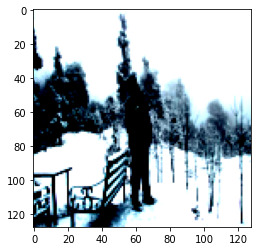

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


teenager carrying a tray of bananas


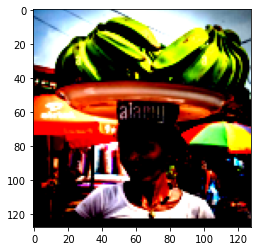

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


girl selling fans in a market


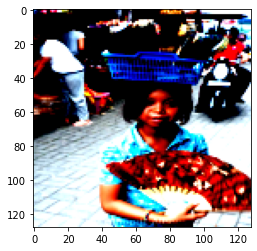

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


discharge of water from a metal pipe in the river


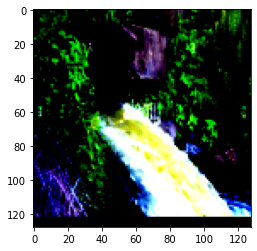

In [ ]:
labels = {}
with open(os.path.join(FLAGS['data_dir'], 'mappings.csv')) as csvfile:
    r = csv.reader(csvfile, delimiter=',', quotechar='|')
    try:
        for row in r:
            labels[row[0]] = row[1]
    except:
        pass

img, label = train_dataset[100]
print(label)
plt.imshow(img.permute(1, 2, 0))
plt.show()
img, label = train_dataset[101]
print(label)
plt.imshow(img.permute(1, 2, 0))
plt.show()
img, label = train_dataset[102]
print(label)
plt.imshow(img.permute(1, 2, 0))
plt.show()
img, label = train_dataset[103]
print(label)
plt.imshow(img.permute(1, 2, 0))
plt.show()

# Vector Quantization Layer
Adapted from https://github.com/zalandoresearch/pytorch-vq-vae

In [ ]:
class VectorQuantizer(nn.Module):
    def __init__(self, num_embeddings, embedding_dim, commitment_cost):
        super(VectorQuantizer, self).__init__()
        
        self._embedding_dim = embedding_dim
        self._num_embeddings = num_embeddings
        
        self._embedding = nn.Embedding(self._num_embeddings, self._embedding_dim)
        self._embedding.weight.data.uniform_(-1/self._num_embeddings, 1/self._num_embeddings)
        self._commitment_cost = commitment_cost

    def forward(self, inputs):
        # convert inputs from BCHW -> BHWC
        inputs = inputs.permute(0, 2, 3, 1).contiguous()
        input_shape = inputs.shape
        
        # Flatten input
        flat_input = inputs.view(-1, self._embedding_dim)
        
        # Calculate distances
        distances = (torch.sum(flat_input**2, dim=1, keepdim=True) 
                    + torch.sum(self._embedding.weight**2, dim=1)
                    - 2 * torch.matmul(flat_input, self._embedding.weight.t()))
            
        # Encoding
        encoding_indices = torch.argmin(distances, dim=1).unsqueeze(1)
        encodings = torch.zeros(encoding_indices.shape[0], self._num_embeddings, device=inputs.device)
        encodings.scatter_(1, encoding_indices, 1)
        
        # Quantize and unflatten
        quantized = torch.matmul(encodings, self._embedding.weight).view(input_shape)
        # Loss
        e_latent_loss = F.mse_loss(quantized.detach(), inputs)
        q_latent_loss = F.mse_loss(quantized, inputs.detach())
        loss = q_latent_loss + self._commitment_cost * e_latent_loss
        
        quantized = inputs + (quantized - inputs).detach()
        avg_probs = torch.mean(encodings, dim=0)
        perplexity = torch.exp(-torch.sum(avg_probs * torch.log(avg_probs + 1e-10)))
        
        # convert quantized from BHWC -> BCHW
        return loss, quantized.permute(0, 3, 1, 2).contiguous(), perplexity, encoding_indices.view(input_shape[0], input_shape[1], input_shape[1])

# Encoder, Decoder, and Model
Inspired by ResNet and DALL-E

In [ ]:
class EncoderBlock (nn.Module):
    def __init__(self, n_in, n_out, downsample=False):
        super(EncoderBlock, self).__init__()
        self.n_hidden = n_out // 2

        if n_in == n_out and downsample:
          self.res = nn.AvgPool2d(kernel_size=2, stride=2)
        elif n_in == n_out and not downsample:
          self.res = nn.Identity()
        elif n_in != n_out and downsample:
          self.res = nn.Conv2d(in_channels=n_in, out_channels=n_out, kernel_size=1, stride=2)
        else:
          self.res = nn.Conv2d(in_channels=n_in, out_channels=n_out, kernel_size=1, stride=1)

        self.enc_block = nn.Sequential(
            nn.ReLU(),
            nn.BatchNorm2d(n_in),
            nn.Conv2d(in_channels=n_in, out_channels=self.n_hidden, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(self.n_hidden),
            nn.Conv2d(in_channels=self.n_hidden, out_channels=self.n_hidden, kernel_size=2, stride=2) if downsample else nn.Conv2d(in_channels=self.n_hidden, out_channels=self.n_hidden, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(self.n_hidden),
            nn.Conv2d(in_channels=self.n_hidden, out_channels=self.n_hidden, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(self.n_hidden),
            nn.Conv2d(in_channels=self.n_hidden, out_channels=n_out, kernel_size=1),
        )


    def forward(self, x):
        return self.enc_block(x) + self.res(x)

In [ ]:
class DecoderBlock (nn.Module):
    def __init__(self, n_in, n_out, upsample=False):
        super(DecoderBlock, self).__init__()

        self.n_hidden = n_out // 2

        if n_in == n_out and upsample:
#           self.res = nn.Upsample(scale_factor=2, mode='nearest')
          self.res = nn.ConvTranspose2d(in_channels=n_in, out_channels=n_out, kernel_size=2, stride=2)
        elif n_in == n_out and not upsample:
          self.res = nn.Identity()
        elif n_in != n_out and upsample:
          self.res = nn.ConvTranspose2d(in_channels=n_in, out_channels=n_out, kernel_size=1, stride=2, padding=1)
        else:
          self.res = nn.ConvTranspose2d(in_channels=n_in, out_channels=n_out, kernel_size=1, stride=1)

        self.enc_block = nn.Sequential(
            nn.ReLU(),
            nn.BatchNorm2d(n_in),
            nn.Conv2d(in_channels=n_in, out_channels=self.n_hidden, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(self.n_hidden),
            nn.ConvTranspose2d(in_channels=self.n_hidden, out_channels=self.n_hidden, kernel_size=2, stride=2) if upsample else nn.Conv2d(in_channels=self.n_hidden, out_channels=self.n_hidden, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(self.n_hidden),
            nn.Conv2d(in_channels=self.n_hidden, out_channels=self.n_hidden, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(self.n_hidden),
            nn.Conv2d(in_channels=self.n_hidden, out_channels=n_out, kernel_size=1),
        )


    def forward(self, x):
        return self.enc_block(x) + self.res(x)

In [ ]:
# Convolutional Autoencoder: ResNet/DALL-E inspired
class ConvAutoencoder(nn.Module):
    def __init__(self, img_size):
        super(ConvAutoencoder, self).__init__()
        self.img_size = img_size

        n_blk = 6
        scale_every = 2 # Downsample/upsample every n blocks
        n_hid = 256
        bottleneck_hid = 1
        
        self.pre_fc_size = int(math.floor(float(img_size)*pow(0.5, scale_every))**2*n_hid)
        self.post_fc_hid = n_hid
        self.post_fc_dim = int(math.floor(float(img_size)*pow(0.5, scale_every)))

        # Encoder
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=n_hid, kernel_size=7, padding=3)

        enc_blocks = []
        for i in range(n_blk):
          enc_blocks.append(EncoderBlock(n_in=n_hid, n_out=n_hid, downsample=((i+1) % scale_every == 0)))

        self.enc_block = nn.Sequential(*enc_blocks)
        
        self.vq = VectorQuantizer(512, n_hid, 0.25)

#         self.bottleneck_in = nn.Sequential(
#             nn.ReLU(),
#             nn.BatchNorm2d(n_hid),
#             nn.Conv2d(in_channels=n_hid, out_channels=bottleneck_hid, kernel_size=1),
#             nn.ReLU(),
#             nn.BatchNorm2d(bottleneck_hid)
#         )
        
        self.bottleneck_out = nn.Sequential(
            nn.ConvTranspose2d(in_channels=bottleneck_hid, out_channels=256, kernel_size=1)
        )

        dec_blocks = []
        for i in range(n_blk):
          dec_blocks.append(DecoderBlock(n_in=n_hid, n_out=n_hid, upsample=((i+1) % scale_every == 0)))

        self.dec_block = nn.Sequential(*dec_blocks)

        self.conv2 = nn.Conv2d(in_channels=n_hid, out_channels=3, kernel_size=1)


    def forward(self, x):
      x = self.conv1(x)
      x = self.enc_block(x)
      loss, quantized, _, encoded = self.vq(x)
#       x = self.bottleneck_out(quantized)
      x = self.dec_block(quantized)
      x = self.conv2(x)
      return x, loss, encoded


#Instantiate the model
model = ConvAutoencoder(FLAGS['img_size']).to(device)
# try:
#     model.load_state_dict(torch.load('./img_model'))
# except:
#     pass

# Perceptual Loss Using ResNet 18

In [ ]:
class PerceptualLoss(nn.Module):
    def __init__(self):
        super(PerceptualLoss, self).__init__()
        
        self.perceptual_model = torch.hub.load('pytorch/vision:v0.10.0', 'resnet18', pretrained=True)

    def forward(self, src, tgt):
        x0 = self.perceptual_model.conv1(src)
        x1 = self.perceptual_model.conv1(tgt)
        x0 = self.perceptual_model.bn1(x0)
        x1 = self.perceptual_model.bn1(x1)
        x0 = self.perceptual_model.relu(x0)
        x1 = self.perceptual_model.relu(x1)
        x0 = self.perceptual_model.maxpool(x0)
        x1 = self.perceptual_model.maxpool(x1)
        x0 = self.perceptual_model.layer1(x0)
        x1 = self.perceptual_model.layer1(x1)
        x0 = self.perceptual_model.layer2(x0)
        x1 = self.perceptual_model.layer2(x1)
#         x0 = self.perceptual_model.layer3(x0)
#         x1 = self.perceptual_model.layer3(x1)
#         x0 = self.perceptual_model.layer4(x0)
#         x1 = self.perceptual_model.layer4(x1)
        return F.mse_loss(x0, x1.detach())
perceptual_loss = PerceptualLoss().to(device)

Using cache found in /home/u1088336/.cache/torch/hub/pytorch_vision_v0.10.0


In [ ]:
learning_rate = FLAGS['learning_rate'] * xm.xrt_world_size()

#Loss function
# perceptual_model = torch.hub.load('pytorch/vision:v0.10.0', 'resnet18', pretrained=True).to(device)

#Optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
lambda1 = lambda epoch: 0.65 ** epoch
scheduler = torch.optim.lr_scheduler.LambdaLR(optimizer, lr_lambda=lambda1)

# Train the Model

In [ ]:
def train():
    torch.manual_seed(1)
    def train_loop_fn(loader):
        tracker = xm.RateTracker()
        model.train()
        perceptual_loss.train()
        for param in perceptual_loss.parameters():
            param.requires_grad = False
        for x, data in enumerate(loader):
            img = data[0]
            optimizer.zero_grad()
            output, vq_loss, hidden = model(img)
#             recon_error = F.mse_loss(output, img)
            recon_error = perceptual_loss(output, img)
            loss = recon_error + vq_loss
            loss.backward()
            xm.optimizer_step(optimizer)
            tracker.add(FLAGS['batch_size'])
            if x % FLAGS['log_steps'] == 0:
                print('[xla:{}]({}) Loss={:.5f} Rate={:.2f} GlobalRate={:.2f} LR={:.9f}'.format(
                    xm.get_ordinal(), x, loss.item(), tracker.rate(),
                    tracker.global_rate(), scheduler.get_lr()[0]), flush=True)
                
    def test_loop_fn(loader, best_loss):
        total_samples = 0
        loss = 0.0
        model.eval()
        perceptual_loss.eval()
        with torch.no_grad():
            for data in loader:
                img = data[0]
                output, vq_loss, hidden = model(img)
                recon_error = perceptual_loss(output, img)
                loss_tmp = recon_error + vq_loss
                loss += loss_tmp.item()
                total_samples += 1

        total_loss = loss / total_samples
        bl = best_loss
        print('[xla:{}] Validation Loss={:.2f}'.format(
            xm.get_ordinal(), total_loss), flush=True)
        if total_loss < bl:
            print('Saving model...', flush=True)
            torch.save(model.state_dict(), './img_model')
            bl = total_loss
        return bl
    
    # Train and eval loops
    best_test_loss = 999999
    accuracy = 0.0
    data, pred, target = None, None, None
    for epoch in range(1, FLAGS['num_epochs'] + 1):
        para_loader = pl.ParallelLoader(train_loader, [device])
        train_loop_fn(para_loader.per_device_loader(device))
        xm.master_print("Finished training epoch {}".format(epoch))
        para_loader = pl.ParallelLoader(test_loader, [device])
        best_test_loss = test_loop_fn(para_loader.per_device_loader(device), best_test_loss)
        scheduler.step()

In [ ]:
# Start training processes
def _mp_fn(rank, flags):
    global FLAGS
    FLAGS = flags
    torch.set_default_tensor_type('torch.FloatTensor')
    train()

xmp.spawn(_mp_fn, args=(FLAGS,), nprocs=FLAGS['num_cores'], start_method='fork')

[xla:0](0) Loss=1.89806 Rate=6.87 GlobalRate=6.87 LR=0.001000000


/opt/conda/lib/python3.7/site-packages/torch/optim/lr_scheduler.py:247: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


[xla:0](100) Loss=3.02230 Rate=50.94 GlobalRate=72.63 LR=0.001000000
[xla:0](200) Loss=1.72174 Rate=107.97 GlobalRate=96.84 LR=0.001000000
[xla:0](300) Loss=1.06066 Rate=130.91 GlobalRate=109.07 LR=0.001000000
[xla:0](400) Loss=0.75947 Rate=140.17 GlobalRate=116.47 LR=0.001000000
[xla:0](500) Loss=0.58126 Rate=131.78 GlobalRate=118.29 LR=0.001000000
[xla:0](600) Loss=0.48276 Rate=129.41 GlobalRate=119.78 LR=0.001000000
[xla:0](700) Loss=0.40650 Rate=127.22 GlobalRate=120.59 LR=0.001000000
[xla:0](800) Loss=0.38059 Rate=124.77 GlobalRate=120.91 LR=0.001000000
[xla:0](900) Loss=0.39914 Rate=127.22 GlobalRate=121.74 LR=0.001000000
[xla:0](1000) Loss=0.34653 Rate=129.70 GlobalRate=122.64 LR=0.001000000
[xla:0](1100) Loss=0.28614 Rate=127.03 GlobalRate=122.87 LR=0.001000000


/opt/conda/lib/python3.7/site-packages/PIL/TiffImagePlugin.py:819: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))


[xla:0](1200) Loss=0.28645 Rate=123.80 GlobalRate=122.77 LR=0.001000000
[xla:0](1300) Loss=0.24923 Rate=124.86 GlobalRate=122.98 LR=0.001000000
[xla:0](1400) Loss=0.26177 Rate=128.90 GlobalRate=123.56 LR=0.001000000
[xla:0](1500) Loss=0.27640 Rate=125.74 GlobalRate=123.56 LR=0.001000000
[xla:0](1600) Loss=0.23068 Rate=127.56 GlobalRate=123.87 LR=0.001000000
[xla:0](1700) Loss=0.22638 Rate=130.28 GlobalRate=124.33 LR=0.001000000
[xla:0](1800) Loss=0.21868 Rate=125.97 GlobalRate=124.26 LR=0.001000000
[xla:0](1900) Loss=0.19165 Rate=127.52 GlobalRate=124.48 LR=0.001000000
[xla:0](2000) Loss=0.18812 Rate=129.26 GlobalRate=124.76 LR=0.001000000
[xla:0](2100) Loss=0.20593 Rate=129.45 GlobalRate=124.98 LR=0.001000000
[xla:0](2200) Loss=0.17968 Rate=126.42 GlobalRate=124.96 LR=0.001000000
[xla:0](2300) Loss=0.19368 Rate=127.43 GlobalRate=125.09 LR=0.001000000


/opt/conda/lib/python3.7/site-packages/PIL/TiffImagePlugin.py:819: UserWarning: Corrupt EXIF data.  Expecting to read 12 bytes but only got 8. 
  warnings.warn(str(msg))


[xla:0](2400) Loss=0.16868 Rate=123.91 GlobalRate=124.94 LR=0.001000000
[xla:0](2500) Loss=0.17000 Rate=125.54 GlobalRate=125.01 LR=0.001000000
[xla:0](2600) Loss=0.15453 Rate=125.60 GlobalRate=125.03 LR=0.001000000
[xla:0](2700) Loss=0.16121 Rate=126.37 GlobalRate=125.10 LR=0.001000000
[xla:0](2800) Loss=0.16206 Rate=125.95 GlobalRate=125.12 LR=0.001000000
[xla:0](2900) Loss=0.15172 Rate=124.76 GlobalRate=125.08 LR=0.001000000
[xla:0](3000) Loss=0.14474 Rate=124.90 GlobalRate=125.08 LR=0.001000000


/opt/conda/lib/python3.7/site-packages/PIL/Image.py:2921: DecompressionBombWarning: Image size (93950400 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  DecompressionBombWarning,


[xla:0](3100) Loss=0.14025 Rate=127.47 GlobalRate=125.20 LR=0.001000000
[xla:0](3200) Loss=0.13904 Rate=123.00 GlobalRate=125.04 LR=0.001000000
[xla:0](3300) Loss=0.13885 Rate=121.80 GlobalRate=124.91 LR=0.001000000
[xla:0](3400) Loss=0.13366 Rate=125.80 GlobalRate=125.01 LR=0.001000000
[xla:0](3500) Loss=0.13441 Rate=127.94 GlobalRate=125.13 LR=0.001000000
[xla:0](3600) Loss=0.13066 Rate=125.03 GlobalRate=125.07 LR=0.001000000
[xla:0](3700) Loss=0.12914 Rate=123.96 GlobalRate=125.02 LR=0.001000000
[xla:0](3800) Loss=0.12320 Rate=123.54 GlobalRate=124.98 LR=0.001000000
[xla:0](3900) Loss=0.14411 Rate=123.96 GlobalRate=124.96 LR=0.001000000
[xla:0](4000) Loss=0.12721 Rate=125.91 GlobalRate=125.01 LR=0.001000000
[xla:0](4100) Loss=0.13016 Rate=127.16 GlobalRate=125.08 LR=0.001000000
[xla:0](4200) Loss=0.11975 Rate=124.10 GlobalRate=125.01 LR=0.001000000
[xla:0](4300) Loss=0.13102 Rate=123.17 GlobalRate=124.95 LR=0.001000000
[xla:0](4400) Loss=0.12506 Rate=129.02 GlobalRate=125.12 LR=0.00

/opt/conda/lib/python3.7/site-packages/PIL/Image.py:2921: DecompressionBombWarning: Image size (107736028 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  DecompressionBombWarning,


[xla:0](6400) Loss=0.10705 Rate=121.49 GlobalRate=125.17 LR=0.001000000
Finished training epoch 1


/opt/conda/lib/python3.7/site-packages/PIL/Image.py:2921: DecompressionBombWarning: Image size (136901120 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  DecompressionBombWarning,
/opt/conda/lib/python3.7/site-packages/PIL/TiffImagePlugin.py:819: UserWarning: Truncated File Read
  warnings.warn(str(msg))
/opt/conda/lib/python3.7/site-packages/PIL/TiffImagePlugin.py:819: UserWarning: Truncated File Read
  warnings.warn(str(msg))


[xla:0] Validation Loss=0.16
Saving model...
[xla:0](0) Loss=0.10920 Rate=25.56 GlobalRate=25.56 LR=0.000650000
[xla:0](100) Loss=0.11692 Rate=84.99 GlobalRate=120.01 LR=0.000650000
[xla:0](200) Loss=0.11609 Rate=108.47 GlobalRate=122.02 LR=0.000650000
[xla:0](300) Loss=0.10828 Rate=116.78 GlobalRate=122.12 LR=0.000650000
[xla:0](400) Loss=0.10770 Rate=122.27 GlobalRate=123.05 LR=0.000650000
[xla:0](500) Loss=0.11007 Rate=121.75 GlobalRate=122.72 LR=0.000650000
[xla:0](600) Loss=0.10764 Rate=124.78 GlobalRate=123.38 LR=0.000650000
[xla:0](700) Loss=0.10643 Rate=125.88 GlobalRate=123.83 LR=0.000650000
[xla:0](800) Loss=0.11022 Rate=124.09 GlobalRate=123.71 LR=0.000650000
[xla:0](900) Loss=0.12587 Rate=127.18 GlobalRate=124.30 LR=0.000650000
[xla:0](1000) Loss=0.11708 Rate=127.60 GlobalRate=124.65 LR=0.000650000
[xla:0](1100) Loss=0.10573 Rate=128.14 GlobalRate=124.99 LR=0.000650000


/opt/conda/lib/python3.7/site-packages/PIL/TiffImagePlugin.py:819: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))


[xla:0](1200) Loss=0.11126 Rate=123.35 GlobalRate=124.57 LR=0.000650000
[xla:0](1300) Loss=0.10124 Rate=125.30 GlobalRate=124.73 LR=0.000650000
[xla:0](1400) Loss=0.11256 Rate=130.03 GlobalRate=125.29 LR=0.000650000
[xla:0](1500) Loss=0.12071 Rate=126.42 GlobalRate=125.21 LR=0.000650000
[xla:0](1600) Loss=0.11072 Rate=128.05 GlobalRate=125.45 LR=0.000650000
[xla:0](1700) Loss=0.11101 Rate=129.67 GlobalRate=125.75 LR=0.000650000
[xla:0](1800) Loss=0.11528 Rate=127.18 GlobalRate=125.73 LR=0.000650000
[xla:0](1900) Loss=0.10792 Rate=126.95 GlobalRate=125.79 LR=0.000650000
[xla:0](2000) Loss=0.10692 Rate=129.02 GlobalRate=126.01 LR=0.000650000
[xla:0](2100) Loss=0.11914 Rate=130.16 GlobalRate=126.24 LR=0.000650000
[xla:0](2200) Loss=0.10482 Rate=125.74 GlobalRate=126.08 LR=0.000650000
[xla:0](2300) Loss=0.11865 Rate=127.10 GlobalRate=126.16 LR=0.000650000


/opt/conda/lib/python3.7/site-packages/PIL/TiffImagePlugin.py:819: UserWarning: Corrupt EXIF data.  Expecting to read 12 bytes but only got 8. 
  warnings.warn(str(msg))


[xla:0](2400) Loss=0.10844 Rate=125.11 GlobalRate=126.06 LR=0.000650000
[xla:0](2500) Loss=0.11151 Rate=125.13 GlobalRate=126.02 LR=0.000650000
[xla:0](2600) Loss=0.11367 Rate=125.71 GlobalRate=126.02 LR=0.000650000
[xla:0](2700) Loss=0.11097 Rate=125.22 GlobalRate=125.98 LR=0.000650000
[xla:0](2800) Loss=0.11116 Rate=127.36 GlobalRate=126.08 LR=0.000650000
[xla:0](2900) Loss=0.11372 Rate=119.08 GlobalRate=125.60 LR=0.000650000
[xla:0](3000) Loss=0.11168 Rate=128.80 GlobalRate=125.90 LR=0.000650000


/opt/conda/lib/python3.7/site-packages/PIL/Image.py:2921: DecompressionBombWarning: Image size (93950400 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  DecompressionBombWarning,


[xla:0](3100) Loss=0.23274 Rate=128.67 GlobalRate=125.99 LR=0.000650000
[xla:0](3200) Loss=0.11286 Rate=123.18 GlobalRate=125.78 LR=0.000650000
[xla:0](3300) Loss=0.10897 Rate=122.66 GlobalRate=125.67 LR=0.000650000
[xla:0](3400) Loss=0.10964 Rate=125.92 GlobalRate=125.74 LR=0.000650000
[xla:0](3500) Loss=0.11202 Rate=127.91 GlobalRate=125.83 LR=0.000650000
[xla:0](3600) Loss=0.10806 Rate=126.47 GlobalRate=125.83 LR=0.000650000
[xla:0](3700) Loss=0.10458 Rate=123.23 GlobalRate=125.69 LR=0.000650000
[xla:0](3800) Loss=0.10268 Rate=124.57 GlobalRate=125.69 LR=0.000650000
[xla:0](3900) Loss=0.10935 Rate=123.57 GlobalRate=125.61 LR=0.000650000
[xla:0](4000) Loss=0.10376 Rate=125.79 GlobalRate=125.65 LR=0.000650000
[xla:0](4100) Loss=0.11099 Rate=125.04 GlobalRate=125.63 LR=0.000650000
[xla:0](4200) Loss=0.10006 Rate=124.87 GlobalRate=125.61 LR=0.000650000
[xla:0](4300) Loss=0.10278 Rate=123.79 GlobalRate=125.55 LR=0.000650000
[xla:0](4400) Loss=0.10351 Rate=128.84 GlobalRate=125.69 LR=0.00

/opt/conda/lib/python3.7/site-packages/PIL/Image.py:2921: DecompressionBombWarning: Image size (107736028 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  DecompressionBombWarning,


[xla:0](6400) Loss=0.09261 Rate=121.95 GlobalRate=125.54 LR=0.000650000
Finished training epoch 2


/opt/conda/lib/python3.7/site-packages/PIL/Image.py:2921: DecompressionBombWarning: Image size (136901120 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  DecompressionBombWarning,
/opt/conda/lib/python3.7/site-packages/PIL/TiffImagePlugin.py:819: UserWarning: Truncated File Read
  warnings.warn(str(msg))
/opt/conda/lib/python3.7/site-packages/PIL/TiffImagePlugin.py:819: UserWarning: Truncated File Read
  warnings.warn(str(msg))


[xla:0] Validation Loss=0.18
[xla:0](0) Loss=0.11826 Rate=25.58 GlobalRate=25.58 LR=0.000422500
[xla:0](100) Loss=0.09796 Rate=85.27 GlobalRate=120.42 LR=0.000422500
[xla:0](200) Loss=0.10465 Rate=107.65 GlobalRate=121.48 LR=0.000422500
[xla:0](300) Loss=0.09794 Rate=116.98 GlobalRate=122.05 LR=0.000422500
[xla:0](400) Loss=0.09518 Rate=124.23 GlobalRate=123.72 LR=0.000422500
[xla:0](500) Loss=0.11074 Rate=121.00 GlobalRate=122.72 LR=0.000422500
[xla:0](600) Loss=0.11616 Rate=124.53 GlobalRate=123.39 LR=0.000422500
[xla:0](700) Loss=0.09086 Rate=126.45 GlobalRate=123.99 LR=0.000422500
[xla:0](800) Loss=0.09688 Rate=124.08 GlobalRate=123.80 LR=0.000422500
[xla:0](900) Loss=0.10775 Rate=127.22 GlobalRate=124.39 LR=0.000422500
[xla:0](1000) Loss=0.09677 Rate=126.66 GlobalRate=124.58 LR=0.000422500
[xla:0](1100) Loss=0.09115 Rate=128.64 GlobalRate=125.05 LR=0.000422500


/opt/conda/lib/python3.7/site-packages/PIL/TiffImagePlugin.py:819: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))


[xla:0](1200) Loss=0.09267 Rate=124.64 GlobalRate=124.79 LR=0.000422500
[xla:0](1300) Loss=0.08931 Rate=124.74 GlobalRate=124.79 LR=0.000422500
[xla:0](1400) Loss=0.08736 Rate=129.68 GlobalRate=125.34 LR=0.000422500
[xla:0](1500) Loss=0.09848 Rate=126.28 GlobalRate=125.25 LR=0.000422500
[xla:0](1600) Loss=0.10163 Rate=128.58 GlobalRate=125.54 LR=0.000422500
[xla:0](1700) Loss=0.12273 Rate=128.26 GlobalRate=125.69 LR=0.000422500
[xla:0](1800) Loss=0.09930 Rate=127.56 GlobalRate=125.76 LR=0.000422500
[xla:0](1900) Loss=0.09722 Rate=125.97 GlobalRate=125.72 LR=0.000422500
[xla:0](2000) Loss=0.10736 Rate=129.53 GlobalRate=126.01 LR=0.000422500
[xla:0](2100) Loss=0.10732 Rate=128.29 GlobalRate=126.08 LR=0.000422500
[xla:0](2200) Loss=0.09534 Rate=123.85 GlobalRate=125.84 LR=0.000422500
[xla:0](2300) Loss=0.12532 Rate=130.07 GlobalRate=126.18 LR=0.000422500


/opt/conda/lib/python3.7/site-packages/PIL/TiffImagePlugin.py:819: UserWarning: Corrupt EXIF data.  Expecting to read 12 bytes but only got 8. 
  warnings.warn(str(msg))


[xla:0](2400) Loss=0.09283 Rate=125.65 GlobalRate=126.03 LR=0.000422500
[xla:0](2500) Loss=0.09612 Rate=126.18 GlobalRate=126.05 LR=0.000422500
[xla:0](2600) Loss=0.10131 Rate=126.03 GlobalRate=126.05 LR=0.000422500
[xla:0](2700) Loss=0.09830 Rate=125.68 GlobalRate=126.02 LR=0.000422500
[xla:0](2800) Loss=0.09425 Rate=126.99 GlobalRate=126.09 LR=0.000422500
[xla:0](2900) Loss=0.08853 Rate=124.07 GlobalRate=125.95 LR=0.000422500
[xla:0](3000) Loss=0.09564 Rate=124.60 GlobalRate=125.92 LR=0.000422500


/opt/conda/lib/python3.7/site-packages/PIL/Image.py:2921: DecompressionBombWarning: Image size (93950400 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  DecompressionBombWarning,


[xla:0](3100) Loss=0.09153 Rate=127.43 GlobalRate=126.02 LR=0.000422500
[xla:0](3200) Loss=0.09081 Rate=122.69 GlobalRate=125.81 LR=0.000422500
[xla:0](3300) Loss=0.09485 Rate=122.43 GlobalRate=125.70 LR=0.000422500
[xla:0](3400) Loss=0.11009 Rate=124.36 GlobalRate=125.70 LR=0.000422500
[xla:0](3500) Loss=0.13696 Rate=128.46 GlobalRate=125.85 LR=0.000422500
[xla:0](3600) Loss=0.10463 Rate=126.18 GlobalRate=125.81 LR=0.000422500
[xla:0](3700) Loss=0.10332 Rate=124.10 GlobalRate=125.73 LR=0.000422500
[xla:0](3800) Loss=0.14686 Rate=124.58 GlobalRate=125.71 LR=0.000422500
[xla:0](3900) Loss=0.11743 Rate=123.20 GlobalRate=125.62 LR=0.000422500
[xla:0](4000) Loss=0.10118 Rate=126.24 GlobalRate=125.68 LR=0.000422500
[xla:0](4100) Loss=0.10567 Rate=125.70 GlobalRate=125.67 LR=0.000422500
[xla:0](4200) Loss=0.10144 Rate=124.58 GlobalRate=125.63 LR=0.000422500
[xla:0](4300) Loss=0.10908 Rate=123.52 GlobalRate=125.56 LR=0.000422500
[xla:0](4400) Loss=0.10555 Rate=128.87 GlobalRate=125.71 LR=0.00

/opt/conda/lib/python3.7/site-packages/PIL/Image.py:2921: DecompressionBombWarning: Image size (107736028 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  DecompressionBombWarning,


[xla:0](6400) Loss=0.09198 Rate=121.32 GlobalRate=125.57 LR=0.000422500
Finished training epoch 3


/opt/conda/lib/python3.7/site-packages/PIL/Image.py:2921: DecompressionBombWarning: Image size (136901120 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  DecompressionBombWarning,
/opt/conda/lib/python3.7/site-packages/PIL/TiffImagePlugin.py:819: UserWarning: Truncated File Read
  warnings.warn(str(msg))
/opt/conda/lib/python3.7/site-packages/PIL/TiffImagePlugin.py:819: UserWarning: Truncated File Read
  warnings.warn(str(msg))


[xla:0] Validation Loss=0.18
[xla:0](0) Loss=0.09291 Rate=24.49 GlobalRate=24.49 LR=0.000274625
[xla:0](100) Loss=0.09433 Rate=84.87 GlobalRate=120.23 LR=0.000274625
[xla:0](200) Loss=0.10997 Rate=107.98 GlobalRate=121.78 LR=0.000274625
[xla:0](300) Loss=0.09158 Rate=116.44 GlobalRate=121.88 LR=0.000274625
[xla:0](400) Loss=0.08972 Rate=123.82 GlobalRate=123.52 LR=0.000274625
[xla:0](500) Loss=0.09250 Rate=121.23 GlobalRate=122.70 LR=0.000274625
[xla:0](600) Loss=0.24854 Rate=124.90 GlobalRate=123.45 LR=0.000274625
[xla:0](700) Loss=0.10956 Rate=125.73 GlobalRate=123.84 LR=0.000274625
[xla:0](800) Loss=0.10139 Rate=124.22 GlobalRate=123.76 LR=0.000274625
[xla:0](900) Loss=0.11223 Rate=127.40 GlobalRate=124.38 LR=0.000274625
[xla:0](1000) Loss=0.10584 Rate=128.82 GlobalRate=124.90 LR=0.000274625
[xla:0](1100) Loss=0.09284 Rate=127.29 GlobalRate=125.02 LR=0.000274625


/opt/conda/lib/python3.7/site-packages/PIL/TiffImagePlugin.py:819: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))


[xla:0](1200) Loss=0.10148 Rate=123.70 GlobalRate=124.70 LR=0.000274625
[xla:0](1300) Loss=0.08966 Rate=125.24 GlobalRate=124.82 LR=0.000274625
[xla:0](1400) Loss=0.09750 Rate=130.19 GlobalRate=125.40 LR=0.000274625
[xla:0](1500) Loss=0.11073 Rate=123.11 GlobalRate=124.91 LR=0.000274625
[xla:0](1600) Loss=0.09587 Rate=130.79 GlobalRate=125.54 LR=0.000274625
[xla:0](1700) Loss=0.09356 Rate=131.50 GlobalRate=125.90 LR=0.000274625
[xla:0](1800) Loss=0.09435 Rate=126.02 GlobalRate=125.70 LR=0.000274625
[xla:0](1900) Loss=0.09220 Rate=127.49 GlobalRate=125.84 LR=0.000274625
[xla:0](2000) Loss=0.09279 Rate=129.03 GlobalRate=126.05 LR=0.000274625
[xla:0](2100) Loss=0.10720 Rate=129.85 GlobalRate=126.25 LR=0.000274625
[xla:0](2200) Loss=0.09025 Rate=126.23 GlobalRate=126.14 LR=0.000274625
[xla:0](2300) Loss=0.10212 Rate=126.89 GlobalRate=126.19 LR=0.000274625


/opt/conda/lib/python3.7/site-packages/PIL/TiffImagePlugin.py:819: UserWarning: Corrupt EXIF data.  Expecting to read 12 bytes but only got 8. 
  warnings.warn(str(msg))


[xla:0](2400) Loss=0.09033 Rate=123.91 GlobalRate=126.00 LR=0.000274625
[xla:0](2500) Loss=0.09746 Rate=125.48 GlobalRate=126.02 LR=0.000274625
[xla:0](2600) Loss=0.08840 Rate=126.02 GlobalRate=126.04 LR=0.000274625
[xla:0](2700) Loss=0.09270 Rate=125.14 GlobalRate=125.98 LR=0.000274625
[xla:0](2800) Loss=0.09177 Rate=125.92 GlobalRate=126.00 LR=0.000274625
[xla:0](2900) Loss=0.08983 Rate=125.15 GlobalRate=125.95 LR=0.000274625
[xla:0](3000) Loss=0.09256 Rate=124.74 GlobalRate=125.90 LR=0.000274625


/opt/conda/lib/python3.7/site-packages/PIL/Image.py:2921: DecompressionBombWarning: Image size (93950400 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  DecompressionBombWarning,


[xla:0](3100) Loss=0.08715 Rate=127.78 GlobalRate=126.02 LR=0.000274625
[xla:0](3200) Loss=0.09004 Rate=122.18 GlobalRate=125.77 LR=0.000274625
[xla:0](3300) Loss=0.08915 Rate=122.55 GlobalRate=125.68 LR=0.000274625
[xla:0](3400) Loss=0.09976 Rate=126.37 GlobalRate=125.77 LR=0.000274625
[xla:0](3500) Loss=0.09509 Rate=127.99 GlobalRate=125.87 LR=0.000274625
[xla:0](3600) Loss=0.09619 Rate=125.40 GlobalRate=125.80 LR=0.000274625
[xla:0](3700) Loss=0.08987 Rate=123.82 GlobalRate=125.72 LR=0.000274625
[xla:0](3800) Loss=0.09770 Rate=124.56 GlobalRate=125.70 LR=0.000274625
[xla:0](3900) Loss=0.10045 Rate=123.02 GlobalRate=125.60 LR=0.000274625
[xla:0](4000) Loss=0.09110 Rate=122.79 GlobalRate=125.53 LR=0.000274625
[xla:0](4100) Loss=0.10166 Rate=128.70 GlobalRate=125.69 LR=0.000274625
[xla:0](4200) Loss=0.09066 Rate=125.00 GlobalRate=125.61 LR=0.000274625
[xla:0](4300) Loss=0.08996 Rate=123.43 GlobalRate=125.54 LR=0.000274625
[xla:0](4400) Loss=0.11407 Rate=129.18 GlobalRate=125.70 LR=0.00

/opt/conda/lib/python3.7/site-packages/PIL/Image.py:2921: DecompressionBombWarning: Image size (107736028 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  DecompressionBombWarning,


[xla:0](6400) Loss=0.08601 Rate=118.02 GlobalRate=125.47 LR=0.000274625
Finished training epoch 4


/opt/conda/lib/python3.7/site-packages/PIL/Image.py:2921: DecompressionBombWarning: Image size (136901120 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  DecompressionBombWarning,
/opt/conda/lib/python3.7/site-packages/PIL/TiffImagePlugin.py:819: UserWarning: Truncated File Read
  warnings.warn(str(msg))
/opt/conda/lib/python3.7/site-packages/PIL/TiffImagePlugin.py:819: UserWarning: Truncated File Read
  warnings.warn(str(msg))


[xla:0] Validation Loss=0.17
[xla:0](0) Loss=0.09821 Rate=26.90 GlobalRate=26.90 LR=0.000178506
[xla:0](100) Loss=0.09380 Rate=85.93 GlobalRate=120.91 LR=0.000178506
[xla:0](200) Loss=0.09194 Rate=108.13 GlobalRate=121.90 LR=0.000178506
[xla:0](300) Loss=0.08991 Rate=117.05 GlobalRate=122.27 LR=0.000178506
[xla:0](400) Loss=0.08770 Rate=123.97 GlobalRate=123.78 LR=0.000178506
[xla:0](500) Loss=0.09358 Rate=121.26 GlobalRate=122.89 LR=0.000178506
[xla:0](600) Loss=0.08781 Rate=124.46 GlobalRate=123.49 LR=0.000178506
[xla:0](700) Loss=0.08787 Rate=124.76 GlobalRate=123.70 LR=0.000178506
[xla:0](800) Loss=0.09623 Rate=120.09 GlobalRate=122.82 LR=0.000178506
[xla:0](900) Loss=0.14422 Rate=131.25 GlobalRate=124.40 LR=0.000178506
[xla:0](1000) Loss=0.09303 Rate=130.11 GlobalRate=124.88 LR=0.000178506
[xla:0](1100) Loss=0.08578 Rate=127.65 GlobalRate=124.98 LR=0.000178506


/opt/conda/lib/python3.7/site-packages/PIL/TiffImagePlugin.py:819: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))


[xla:0](1200) Loss=0.08903 Rate=125.42 GlobalRate=124.89 LR=0.000178506
[xla:0](1300) Loss=0.08600 Rate=124.47 GlobalRate=124.81 LR=0.000178506
[xla:0](1400) Loss=0.08351 Rate=129.17 GlobalRate=125.32 LR=0.000178506
[xla:0](1500) Loss=0.08531 Rate=126.43 GlobalRate=125.27 LR=0.000178506
[xla:0](1600) Loss=0.08769 Rate=128.06 GlobalRate=125.50 LR=0.000178506
[xla:0](1700) Loss=0.09783 Rate=130.06 GlobalRate=125.84 LR=0.000178506
[xla:0](1800) Loss=0.09743 Rate=126.11 GlobalRate=125.70 LR=0.000178506
[xla:0](1900) Loss=0.09139 Rate=126.99 GlobalRate=125.80 LR=0.000178506
[xla:0](2000) Loss=0.08737 Rate=129.97 GlobalRate=126.09 LR=0.000178506
[xla:0](2100) Loss=0.15990 Rate=128.90 GlobalRate=126.19 LR=0.000178506
[xla:0](2200) Loss=0.44550 Rate=125.84 GlobalRate=126.08 LR=0.000178506
[xla:0](2300) Loss=0.16704 Rate=126.90 GlobalRate=126.15 LR=0.000178506


/opt/conda/lib/python3.7/site-packages/PIL/TiffImagePlugin.py:819: UserWarning: Corrupt EXIF data.  Expecting to read 12 bytes but only got 8. 
  warnings.warn(str(msg))


[xla:0](2400) Loss=0.10963 Rate=125.00 GlobalRate=126.04 LR=0.000178506
[xla:0](2500) Loss=0.10864 Rate=125.43 GlobalRate=126.03 LR=0.000178506
[xla:0](2600) Loss=0.09950 Rate=125.90 GlobalRate=126.04 LR=0.000178506
[xla:0](2700) Loss=0.10067 Rate=126.33 GlobalRate=126.06 LR=0.000178506
[xla:0](2800) Loss=0.09858 Rate=125.72 GlobalRate=126.03 LR=0.000178506
[xla:0](2900) Loss=0.09458 Rate=124.78 GlobalRate=125.97 LR=0.000178506
[xla:0](3000) Loss=0.09919 Rate=125.19 GlobalRate=125.95 LR=0.000178506


/opt/conda/lib/python3.7/site-packages/PIL/Image.py:2921: DecompressionBombWarning: Image size (93950400 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  DecompressionBombWarning,


[xla:0](3100) Loss=0.09606 Rate=127.19 GlobalRate=126.03 LR=0.000178506
[xla:0](3200) Loss=0.09377 Rate=122.77 GlobalRate=125.83 LR=0.000178506
[xla:0](3300) Loss=0.09397 Rate=120.48 GlobalRate=125.61 LR=0.000178506
[xla:0](3400) Loss=0.09764 Rate=127.35 GlobalRate=125.78 LR=0.000178506
[xla:0](3500) Loss=0.09572 Rate=129.11 GlobalRate=125.91 LR=0.000178506
[xla:0](3600) Loss=0.09431 Rate=125.02 GlobalRate=125.81 LR=0.000178506
[xla:0](3700) Loss=0.09028 Rate=123.78 GlobalRate=125.73 LR=0.000178506
[xla:0](3800) Loss=0.09058 Rate=124.86 GlobalRate=125.72 LR=0.000178506
[xla:0](3900) Loss=0.10080 Rate=123.16 GlobalRate=125.63 LR=0.000178506
[xla:0](4000) Loss=0.09117 Rate=126.03 GlobalRate=125.68 LR=0.000178506
[xla:0](4100) Loss=0.09683 Rate=126.09 GlobalRate=125.69 LR=0.000178506
[xla:0](4200) Loss=0.08920 Rate=124.02 GlobalRate=125.62 LR=0.000178506
[xla:0](4300) Loss=0.09390 Rate=123.02 GlobalRate=125.54 LR=0.000178506
[xla:0](4400) Loss=0.10806 Rate=128.36 GlobalRate=125.68 LR=0.00

/opt/conda/lib/python3.7/site-packages/PIL/Image.py:2921: DecompressionBombWarning: Image size (107736028 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  DecompressionBombWarning,


[xla:0](6400) Loss=0.10209 Rate=121.43 GlobalRate=125.58 LR=0.000178506
Finished training epoch 5


/opt/conda/lib/python3.7/site-packages/PIL/Image.py:2921: DecompressionBombWarning: Image size (136901120 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  DecompressionBombWarning,
/opt/conda/lib/python3.7/site-packages/PIL/TiffImagePlugin.py:819: UserWarning: Truncated File Read
  warnings.warn(str(msg))
/opt/conda/lib/python3.7/site-packages/PIL/TiffImagePlugin.py:819: UserWarning: Truncated File Read
  warnings.warn(str(msg))


[xla:0] Validation Loss=8.14
[xla:0](0) Loss=0.09710 Rate=24.75 GlobalRate=24.75 LR=0.000116029
[xla:0](100) Loss=0.11166 Rate=84.40 GlobalRate=119.41 LR=0.000116029
[xla:0](200) Loss=0.09977 Rate=107.92 GlobalRate=121.46 LR=0.000116029
[xla:0](300) Loss=0.09812 Rate=117.01 GlobalRate=121.99 LR=0.000116029
[xla:0](400) Loss=0.09217 Rate=124.63 GlobalRate=123.83 LR=0.000116029
[xla:0](500) Loss=0.09401 Rate=121.28 GlobalRate=122.84 LR=0.000116029
[xla:0](600) Loss=0.09370 Rate=124.61 GlobalRate=123.49 LR=0.000116029
[xla:0](700) Loss=0.09306 Rate=126.44 GlobalRate=124.07 LR=0.000116029
[xla:0](800) Loss=0.09238 Rate=124.05 GlobalRate=123.86 LR=0.000116029
[xla:0](900) Loss=0.09998 Rate=127.22 GlobalRate=124.45 LR=0.000116029
[xla:0](1000) Loss=0.09539 Rate=129.59 GlobalRate=125.09 LR=0.000116029
[xla:0](1100) Loss=0.08653 Rate=126.48 GlobalRate=125.03 LR=0.000116029


/opt/conda/lib/python3.7/site-packages/PIL/TiffImagePlugin.py:819: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))


[xla:0](1200) Loss=0.09003 Rate=124.10 GlobalRate=124.81 LR=0.000116029
[xla:0](1300) Loss=0.08635 Rate=124.20 GlobalRate=124.77 LR=0.000116029
[xla:0](1400) Loss=0.08935 Rate=129.08 GlobalRate=125.28 LR=0.000116029
[xla:0](1500) Loss=0.09552 Rate=126.48 GlobalRate=125.25 LR=0.000116029
[xla:0](1600) Loss=0.09195 Rate=128.65 GlobalRate=125.54 LR=0.000116029
[xla:0](1700) Loss=0.08987 Rate=128.67 GlobalRate=125.72 LR=0.000116029
[xla:0](1800) Loss=0.09252 Rate=127.20 GlobalRate=125.75 LR=0.000116029
[xla:0](1900) Loss=0.09113 Rate=126.06 GlobalRate=125.72 LR=0.000116029
[xla:0](2000) Loss=0.09217 Rate=129.27 GlobalRate=126.00 LR=0.000116029
[xla:0](2100) Loss=0.10300 Rate=128.08 GlobalRate=126.06 LR=0.000116029
[xla:0](2200) Loss=0.08866 Rate=127.43 GlobalRate=126.10 LR=0.000116029
[xla:0](2300) Loss=0.09442 Rate=126.49 GlobalRate=126.09 LR=0.000116029


/opt/conda/lib/python3.7/site-packages/PIL/TiffImagePlugin.py:819: UserWarning: Corrupt EXIF data.  Expecting to read 12 bytes but only got 8. 
  warnings.warn(str(msg))


[xla:0](2400) Loss=0.09014 Rate=125.36 GlobalRate=126.03 LR=0.000116029
[xla:0](2500) Loss=0.09153 Rate=125.26 GlobalRate=125.99 LR=0.000116029
[xla:0](2600) Loss=0.08949 Rate=124.09 GlobalRate=125.89 LR=0.000116029
[xla:0](2700) Loss=0.08870 Rate=128.15 GlobalRate=126.07 LR=0.000116029
[xla:0](2800) Loss=0.08892 Rate=126.41 GlobalRate=126.04 LR=0.000116029
[xla:0](2900) Loss=0.08411 Rate=124.56 GlobalRate=125.94 LR=0.000116029
[xla:0](3000) Loss=0.09585 Rate=124.40 GlobalRate=125.89 LR=0.000116029


/opt/conda/lib/python3.7/site-packages/PIL/Image.py:2921: DecompressionBombWarning: Image size (93950400 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  DecompressionBombWarning,


[xla:0](3100) Loss=0.08624 Rate=127.58 GlobalRate=126.00 LR=0.000116029
[xla:0](3200) Loss=0.08618 Rate=122.56 GlobalRate=125.78 LR=0.000116029
[xla:0](3300) Loss=0.08921 Rate=122.25 GlobalRate=125.66 LR=0.000116029
[xla:0](3400) Loss=0.08840 Rate=126.19 GlobalRate=125.75 LR=0.000116029
[xla:0](3500) Loss=0.09074 Rate=128.04 GlobalRate=125.85 LR=0.000116029
[xla:0](3600) Loss=0.09396 Rate=125.63 GlobalRate=125.80 LR=0.000116029
[xla:0](3700) Loss=0.08500 Rate=124.07 GlobalRate=125.72 LR=0.000116029
[xla:0](3800) Loss=0.08630 Rate=122.67 GlobalRate=125.62 LR=0.000116029
[xla:0](3900) Loss=0.08967 Rate=124.34 GlobalRate=125.61 LR=0.000116029
[xla:0](4000) Loss=0.08391 Rate=126.70 GlobalRate=125.68 LR=0.000116029
[xla:0](4100) Loss=0.08995 Rate=125.56 GlobalRate=125.66 LR=0.000116029
[xla:0](4200) Loss=0.08831 Rate=123.95 GlobalRate=125.59 LR=0.000116029
[xla:0](4300) Loss=0.08797 Rate=123.41 GlobalRate=125.53 LR=0.000116029
[xla:0](4400) Loss=0.08382 Rate=128.11 GlobalRate=125.65 LR=0.00

/opt/conda/lib/python3.7/site-packages/PIL/Image.py:2921: DecompressionBombWarning: Image size (107736028 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  DecompressionBombWarning,


[xla:0](6400) Loss=0.08485 Rate=122.52 GlobalRate=125.55 LR=0.000116029
Finished training epoch 6


/opt/conda/lib/python3.7/site-packages/PIL/Image.py:2921: DecompressionBombWarning: Image size (136901120 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  DecompressionBombWarning,
/opt/conda/lib/python3.7/site-packages/PIL/TiffImagePlugin.py:819: UserWarning: Truncated File Read
  warnings.warn(str(msg))
/opt/conda/lib/python3.7/site-packages/PIL/TiffImagePlugin.py:819: UserWarning: Truncated File Read
  warnings.warn(str(msg))


[xla:0] Validation Loss=8.33
[xla:0](0) Loss=0.08582 Rate=26.42 GlobalRate=26.42 LR=0.000075419
[xla:0](100) Loss=0.08647 Rate=85.10 GlobalRate=119.82 LR=0.000075419
[xla:0](200) Loss=0.08659 Rate=108.66 GlobalRate=122.04 LR=0.000075419
[xla:0](300) Loss=0.09016 Rate=116.30 GlobalRate=121.82 LR=0.000075419
[xla:0](400) Loss=0.08405 Rate=124.37 GlobalRate=123.71 LR=0.000075419
[xla:0](500) Loss=0.08703 Rate=120.50 GlobalRate=122.51 LR=0.000075419
[xla:0](600) Loss=0.08762 Rate=124.57 GlobalRate=123.28 LR=0.000075419
[xla:0](700) Loss=0.08323 Rate=125.22 GlobalRate=123.61 LR=0.000075419
[xla:0](800) Loss=0.08667 Rate=124.93 GlobalRate=123.75 LR=0.000075419
[xla:0](900) Loss=0.08907 Rate=127.42 GlobalRate=124.32 LR=0.000075419
[xla:0](1000) Loss=0.08532 Rate=129.08 GlobalRate=124.88 LR=0.000075419
[xla:0](1100) Loss=0.08528 Rate=127.61 GlobalRate=125.04 LR=0.000075419


/opt/conda/lib/python3.7/site-packages/PIL/TiffImagePlugin.py:819: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))


[xla:0](1200) Loss=0.08336 Rate=124.81 GlobalRate=124.86 LR=0.000075419
[xla:0](1300) Loss=0.08221 Rate=124.05 GlobalRate=124.76 LR=0.000075419
[xla:0](1400) Loss=0.08215 Rate=129.58 GlobalRate=125.33 LR=0.000075419
[xla:0](1500) Loss=0.08371 Rate=126.15 GlobalRate=125.23 LR=0.000075419


KeyboardInterrupt: 

# Show Encoded Images

Original Images


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


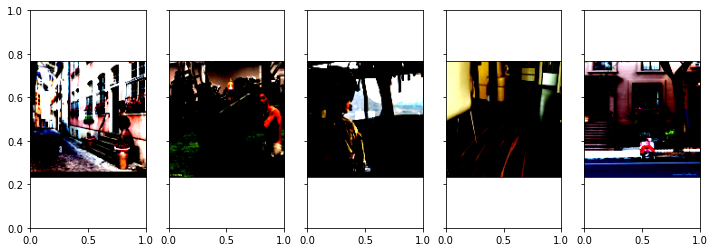

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Reconstructed Images


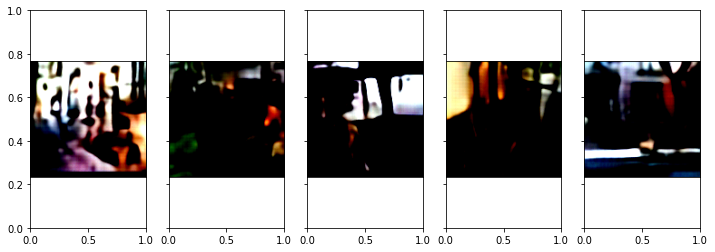

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Test Reconstructed Images


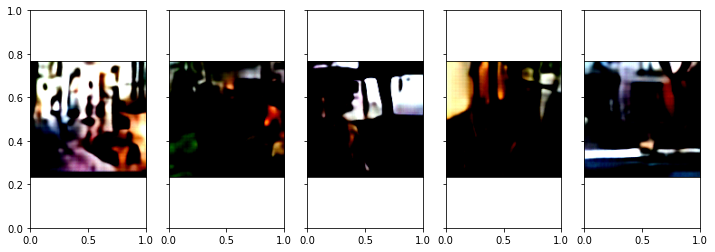

In [ ]:
model = ConvAutoencoder(FLAGS['img_size']).to(device)
model.load_state_dict(torch.load('./img_model_backup'))

#Batch of test images
dataiter = iter(test_loader)
images = dataiter.next()

#Sample outputs
output = model(images[0].to(device))
images = images[0].numpy()

encoded = model.vq._embedding(output[2]).permute(0, 3, 1, 2).contiguous()
test_output = model.dec_block(encoded)
test_output = model.conv2(test_output)
test_output = test_output.view(FLAGS['batch_size'], 3, FLAGS['img_size'], FLAGS['img_size'])
test_output = test_output.detach().cpu().numpy()

output = output[0].view(FLAGS['batch_size'], 3, FLAGS['img_size'], FLAGS['img_size'])
output = output.detach().cpu().numpy()

def imshow(img):
    #img = img / 2 + 0.5  
    plt.imshow(np.transpose(img, (1, 2, 0))) 
    
im = Image.fromarray(np.uint8(np.transpose(images[0], (1, 2, 0))))
im.save("orig.jpg")
im = Image.fromarray(np.uint8(np.transpose(output[0], (1, 2, 0))))
im.save("recon.jpg")

#Original Images
print("Original Images")
fig, axes = plt.subplots(nrows=1, ncols=5, sharex=True, sharey=True, figsize=(12,4))
for idx in np.arange(5):
    ax = fig.add_subplot(1, 5, idx+1, xticks=[], yticks=[])
    imshow(images[idx])
plt.show()

#Reconstructed Images
print('Reconstructed Images')
fig, axes = plt.subplots(nrows=1, ncols=5, sharex=True, sharey=True, figsize=(12,4))
for idx in np.arange(5):
    ax = fig.add_subplot(1, 5, idx+1, xticks=[], yticks=[])
    imshow(output[idx])
plt.show()

#Reconstructed Images
print('Test Reconstructed Images')
fig, axes = plt.subplots(nrows=1, ncols=5, sharex=True, sharey=True, figsize=(12,4))
for idx in np.arange(5):
    ax = fig.add_subplot(1, 5, idx+1, xticks=[], yticks=[])
    imshow(test_output[idx])
plt.show() 